In [18]:
# Imports
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
import csv
import visJS2jupyter.visualizations as visualizations
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Blues8, Reds8, Purples8, Oranges8, Viridis8, Spectral8
from bokeh.transform import linear_cmap
from networkx.algorithms import community
from bokeh.models import EdgesAndLinkedNodes, NodesAndLinkedEdges
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot

##### Network Data Cleaning

In [19]:
# cleaning and preparing dataframe
def clean_df(df):
  df.columns = df.columns.str.replace(r'_nonpart_part', '')
  df1 = df.copy()
  df1['index'] = df1.index
  contact_type_list = ['index', 'friend',	'workmate',	'neighbour',	'familymember',	'partner',	'colleague_association',	'other']
  df1 = df1[contact_type_list]
  df1 = df1.set_index('index').dot(df1.columns[1:] + ', ').str[:-2].reset_index(name='contact_type')
  df_all = pd.concat([df, df1], axis = 1)
  final_columns = ['sender_id','receiver_id','contact_type','frequency','contact_years','trust']
  final_df = df_all.assign(**{col : 'NA' for col in final_columns if col not in df_all.columns})[final_columns]
  final_df = final_df[['sender_id','receiver_id','contact_type','frequency','contact_years','trust']]
  final_df = final_df[final_df['sender_id'].notna()]
  final_df = final_df[final_df['receiver_id'].notna()]
  final_df['sender_id'] = final_df['sender_id'].astype(int)
  final_df['receiver_id'] = final_df['receiver_id'].astype(int)
  na = 0.5
  final_df['trust'] = final_df['trust'].fillna(na)
  final_df['trust'] = np.where(final_df['trust'] == 'NA', na, final_df['trust'])
  final_df['trust'] = pd.to_numeric(final_df['trust'])
  final_df['frequency'] = final_df['frequency'].fillna(na)
  final_df['frequency'] = np.where(final_df['frequency'] == 'NA', na, final_df['frequency'])
  final_df['frequency'] = pd.to_numeric(final_df['frequency'])
  return final_df 

##### Farmers Network Datasets

In [20]:
# There are 4 datasets of the farmers network, sectioned in the following: 

# agro participating farmers connection
part_part_df = pd.read_csv('data/Edges_agroconcept_complete.csv',sep=";")
part_part_df = clean_df(part_part_df)

# agro participating farmers with external connections- the extrenal connection ID looks similar to farmers ID, have a find a way to filter them
part_others_df = pd.read_csv('data/Edges_agroconcept_and_external_contacts.csv',sep=";")
part_others_df = clean_df(part_others_df)

# non participating farmers with all
non_all_df = pd.read_csv('data/Edges_nonpart_all.csv',sep=";")
non_all_df = clean_df(non_all_df)

# non participating farmers with agro participating farmers
non_part_df = pd.read_csv('data/Edges_nonpart_to_agroconcept.csv',sep=";")
non_part_df = clean_df(non_part_df)
non_part_df.head()


,sender_id,receiver_id,contact_type,frequency,contact_years,trust
0,57,21,workmate,1.0,10,0.5
1,58,28,"workmate, other",2.0,50,0.5
2,58,16,"workmate, neighbour",0.0,50,0.5
3,58,4,workmate,0.0,15,0.5
4,58,17,"workmate, neighbour",0.0,15,0.5


In [21]:
# There are 4 datasets that provide us with a list of participating and non-participating farmers 
# and their interview response 

# agro participating farmers
att_part_int_df = pd.read_csv('data/Atts_agroconcept_int.csv',sep=";")
part_list = att_part_int_df['ego_id'].tolist()

# agro participating farmers
att_non_int_df = pd.read_csv('data/Atts_nonpart_int.csv',sep=";")
non_list = att_non_int_df['ego_id_nonpart'].tolist()

print("Part Farmer ID: ", part_list)
print("Non-part Farmer ID: ", non_list)

Part Farmer ID:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 26, 27, 28]
Non-part Farmer ID:  [57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81]


##### Interview Dataset Cleaning

In [22]:
def int_data_cleaning(df, group):
    df.columns = df.columns.str.replace(r'_nonpart', '')
    df.columns = df.columns.str.replace(r'consider_', '')
    df.columns = df.columns.str.replace(r'_again', '')
    df['part'] = np.where(df['part'] == 2, 0.5, df['part'])
    df['furt_reduc'] = np.where(df['furt_reduc'] == 2, 0.5, df['part'])
    df1 = df[['part','furt_reduc','CC_import','CC_import_change']].rename(
        columns = {'part':'Future AgroCO2ncept Participation?',
        'furt_reduc':'Further Mitigation Measures?',
        'CC_import':'Climate Change Importance?',
        'CC_import_change':'Climate Change Importance (Today vs 10 Years Ago)?'})
    df2 = df1.mean()
    df2 = pd.DataFrame(df2).reset_index().rename(
        columns = {'index':'Questions', 0: 'Response'})
    df2['Group'] = group
    return df2

all_part_int_stats_df = int_data_cleaning(att_part_int_df, 'Participating')
all_non_int_stats_df = int_data_cleaning(att_non_int_df,'Non-participating')

##### Bar Chart of Average Response from All Farmers

In [ ]:
all_int_response = pd.concat([all_part_int_stats_df, all_non_int_stats_df])

fig, ax = plt.subplots(figsize=(5, 3))

part_colors = ['#a4d2d0','#d2a4a6']
ax = sns.set_palette(sns.color_palette(part_colors))
ax = sns.barplot(data=all_int_response, x="Response", y="Questions", hue="Group")
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')
sns.despine(bottom = False, left = True)
ax.set_title(f'Interview Response (Average) from All {len(att_part_int_df) + len(att_non_int_df)} Farmers')

##### Combining All 4 Network Data

In [23]:
all_farmers_df = pd.concat([part_part_df, part_others_df, non_all_df, non_part_df])
all_farmers_df['participating'] = np.where( all_farmers_df['sender_id'].isin(part_list),'Yes'
, np.where((all_farmers_df['sender_id'].isin(non_list)) & (~all_farmers_df['sender_id'].isin(part_list)), 'No', 'Others' ))
# all_farmers_df.isna().sum() # checking if there are null values in sender_id or receiver_id columns
all_farmers_df = all_farmers_df.drop_duplicates(subset=['sender_id','receiver_id'])
all_farmers_df.head()

,sender_id,receiver_id,contact_type,frequency,contact_years,trust,participating
0,1,2,colleague_association,1.0,NA,4.0,Yes
1,1,20,"workmate, colleague_association",2.0,NA,4.0,Yes
2,1,26,"workmate, colleague_association",1.0,NA,4.0,Yes
3,1,14,"workmate, colleague_association",2.0,NA,4.0,Yes
4,1,15,"workmate, neighbour, colleague_association",2.0,NA,4.0,Yes


#### Networks Statistics for All 4 Datasets

In [24]:
# Nodes Centrality Statistics
part_part_G = nx.from_pandas_edgelist(part_part_df, 'sender_id', 'receiver_id', edge_attr=['frequency','trust'])
part_others_G = nx.from_pandas_edgelist(part_others_df, 'sender_id', 'receiver_id', edge_attr=['frequency','trust'])
non_part_G = nx.from_pandas_edgelist(non_part_df, 'sender_id', 'receiver_id', edge_attr=['frequency','trust'])
non_all_G = nx.from_pandas_edgelist(non_all_df, 'sender_id', 'receiver_id', edge_attr=['frequency','trust'])

def stats(networkx_G, name):
    bc = nx.betweenness_centrality(networkx_G)
    cc = nx.closeness_centrality(networkx_G)
    dc = nx.degree_centrality(networkx_G)
    df1 = pd.DataFrame([bc, cc, dc], index = ['Betweenness','Closeness','Degree']).transpose()
    df2 = df1.sort_values(by=["Degree","Closeness","Betweenness"],ascending=[False,False,False])
    df2.index.names = [name]
    return df2

part_part_stats = stats(part_part_G, 'All Part Farmers')
part_others_stats = stats(part_others_G, 'Part Farmers with Others')
non_part_stats = stats(non_part_G,'Non-part with Part Farmers')
non_all_stats = stats(non_all_G,'Non-part with All')

n = 8
print(f"Top {n} Highest Connectivity amongst Participating Farmers:", part_part_stats[:n].index.to_list())
print(f"Top {n} Highest Connectivity Participating Farmers with Other Contacts:", part_others_stats[:n].index.to_list())
print(f"Top {n} Highest Connectivity Non-participating with Participating Farmers:", non_part_stats[:n].index.to_list())
print(f"Top {n} Highest Connectivity Non-participating Farmers with All:", non_all_stats[:n].index.to_list())

Top 8 Highest Connectivity amongst Participating Farmers: [14, 12, 19, 20, 9, 18, 1, 7]
Top 8 Highest Connectivity Participating Farmers with Other Contacts: [14, 26, 12, 1, 27, 18, 19, 20]
Top 8 Highest Connectivity Non-participating with Participating Farmers: [79, 76, 78, 60, 27, 17, 68, 59]
Top 8 Highest Connectivity Non-participating Farmers with All: [79, 76, 78, 60, 59, 27, 68, 17]


In [25]:
print(part_part_stats[:3])
print(part_others_stats[:3])
print(non_part_stats[:3])
print(non_all_stats[:3])

                  Betweenness  Closeness    Degree
All Part Farmers                                  
14                   0.498518   0.818182  0.777778
12                   0.046975   0.586957  0.370370
19                   0.034157   0.586957  0.333333
                          Betweenness  Closeness  Degree
Part Farmers with Others                                
14                           0.484631   0.617284    0.46
26                           0.214777   0.467290    0.20
12                           0.041994   0.467290    0.20
                            Betweenness  Closeness    Degree
Non-part with Part Farmers                                  
79                             0.299903   0.530612  0.365385
76                             0.162266   0.481481  0.326923
78                             0.137394   0.456140  0.288462
                   Betweenness  Closeness    Degree
Non-part with All                                  
79                    0.272539   0.412921  0.239130

##### Interview Response from Highest Connected Farmers

In [26]:
# Interview response from these top connected farmers 

# Part farmers
top_att_part_int_df = att_part_int_df.loc[att_part_int_df['ego_id'].isin(part_part_stats[:n].index),:]

# Non-part farmers
top_att_non_int_df = att_non_int_df.loc[att_non_int_df['ego_id'].isin(non_part_stats[:n].index),:]

top_part_int_df = int_data_cleaning(top_att_part_int_df, 'Participating')
top_non_int_df = int_data_cleaning(top_att_non_int_df,'Non-participating')

C:\Users\GL\AppData\Local\Temp\ipykernel_11576\3435625087.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\GL\AppData\Local\Temp\ipykernel_11576\3435625087.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\GL\AppData\Local\Temp\ipykernel_11576\3435625087.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

##### Bar Chart of Average Interview Response from Top Connected Farmers

In [ ]:
top_int_response = pd.concat([top_part_int_df, top_non_int_df])

fig, ax = plt.subplots(figsize=(5, 3))
part_colors = ['#a4d2d0','#d2a4a6']
ax = sns.set_palette(sns.color_palette(part_colors))
ax = sns.barplot(data=top_int_response, x="Response", y="Questions", hue="Group")
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')
sns.despine(bottom = False, left = True)
ax.set_title(f'Interview Response (Average) from All {len(top_att_part_int_df) + len(top_att_non_int_df)} Farmers')

##### Network Graph Preparation

In [27]:
#Exclude some nodes to focus the network graph better
exclude_nodes = []
cc_dict = nx.closeness_centrality(non_all_G)
for k,v in cc_dict.items():
    if v < 0.2: 
        exclude_nodes.append(k)
node_list_len = len(exclude_nodes)
print(f"Excluded Nodes with {node_list_len} Minimum Closeness Centrality in Non-participating Farmers Network: ", exclude_nodes)

for node in exclude_nodes:
    non_all_G.remove_node(node)

Excluded Nodes with 20 Minimum Closeness Centrality in Non-participating Farmers Network:  [82, 83, 84, 85, 86, 94, 95, 96, 80, 97, 104, 105, 81, 109, 110, 111, 112, 113, 114, 115]


In [28]:
part_colour = dict.fromkeys(all_farmers_df.receiver_id.tolist() + all_farmers_df.sender_id.tolist())
for key, value in part_colour.items():
    if key in part_list:
        part_colour[key] = '#a4d2d0' # green
    elif key in non_list:
        part_colour[key] = '#d2a4a6' # red
    else:
        part_colour[key] = '#e9e3ae' # yellow   

def colour_mapping(G):
    colour_list =[]
    for node in G.nodes():
        colour_list.append(part_colour[node])
    return colour_list

def edge_color(G, col):
    colour_list =[]
    widths = nx.get_edge_attributes(G, col)
    att_list = list(widths.values())
    for a in att_list:
        if a == 0:
            colour_list.append('#02070e') #dark
        elif a == 1: 
            colour_list.append('#02070e') 
        elif a == 2: 
            colour_list.append('#4c8ee6') 
        elif a == 3: 
            colour_list.append('#4c8ee6') 
        elif a == 4: 
            colour_list.append('#bfd7f6')   
        elif a == 5: 
            colour_list.append('#bfd7f6') #light color       
        else: # all the null rows that we have mapped to non integer values
            colour_list.append('#C37A1B') 
    return colour_list

#### Network Graphs of All 4 Categories

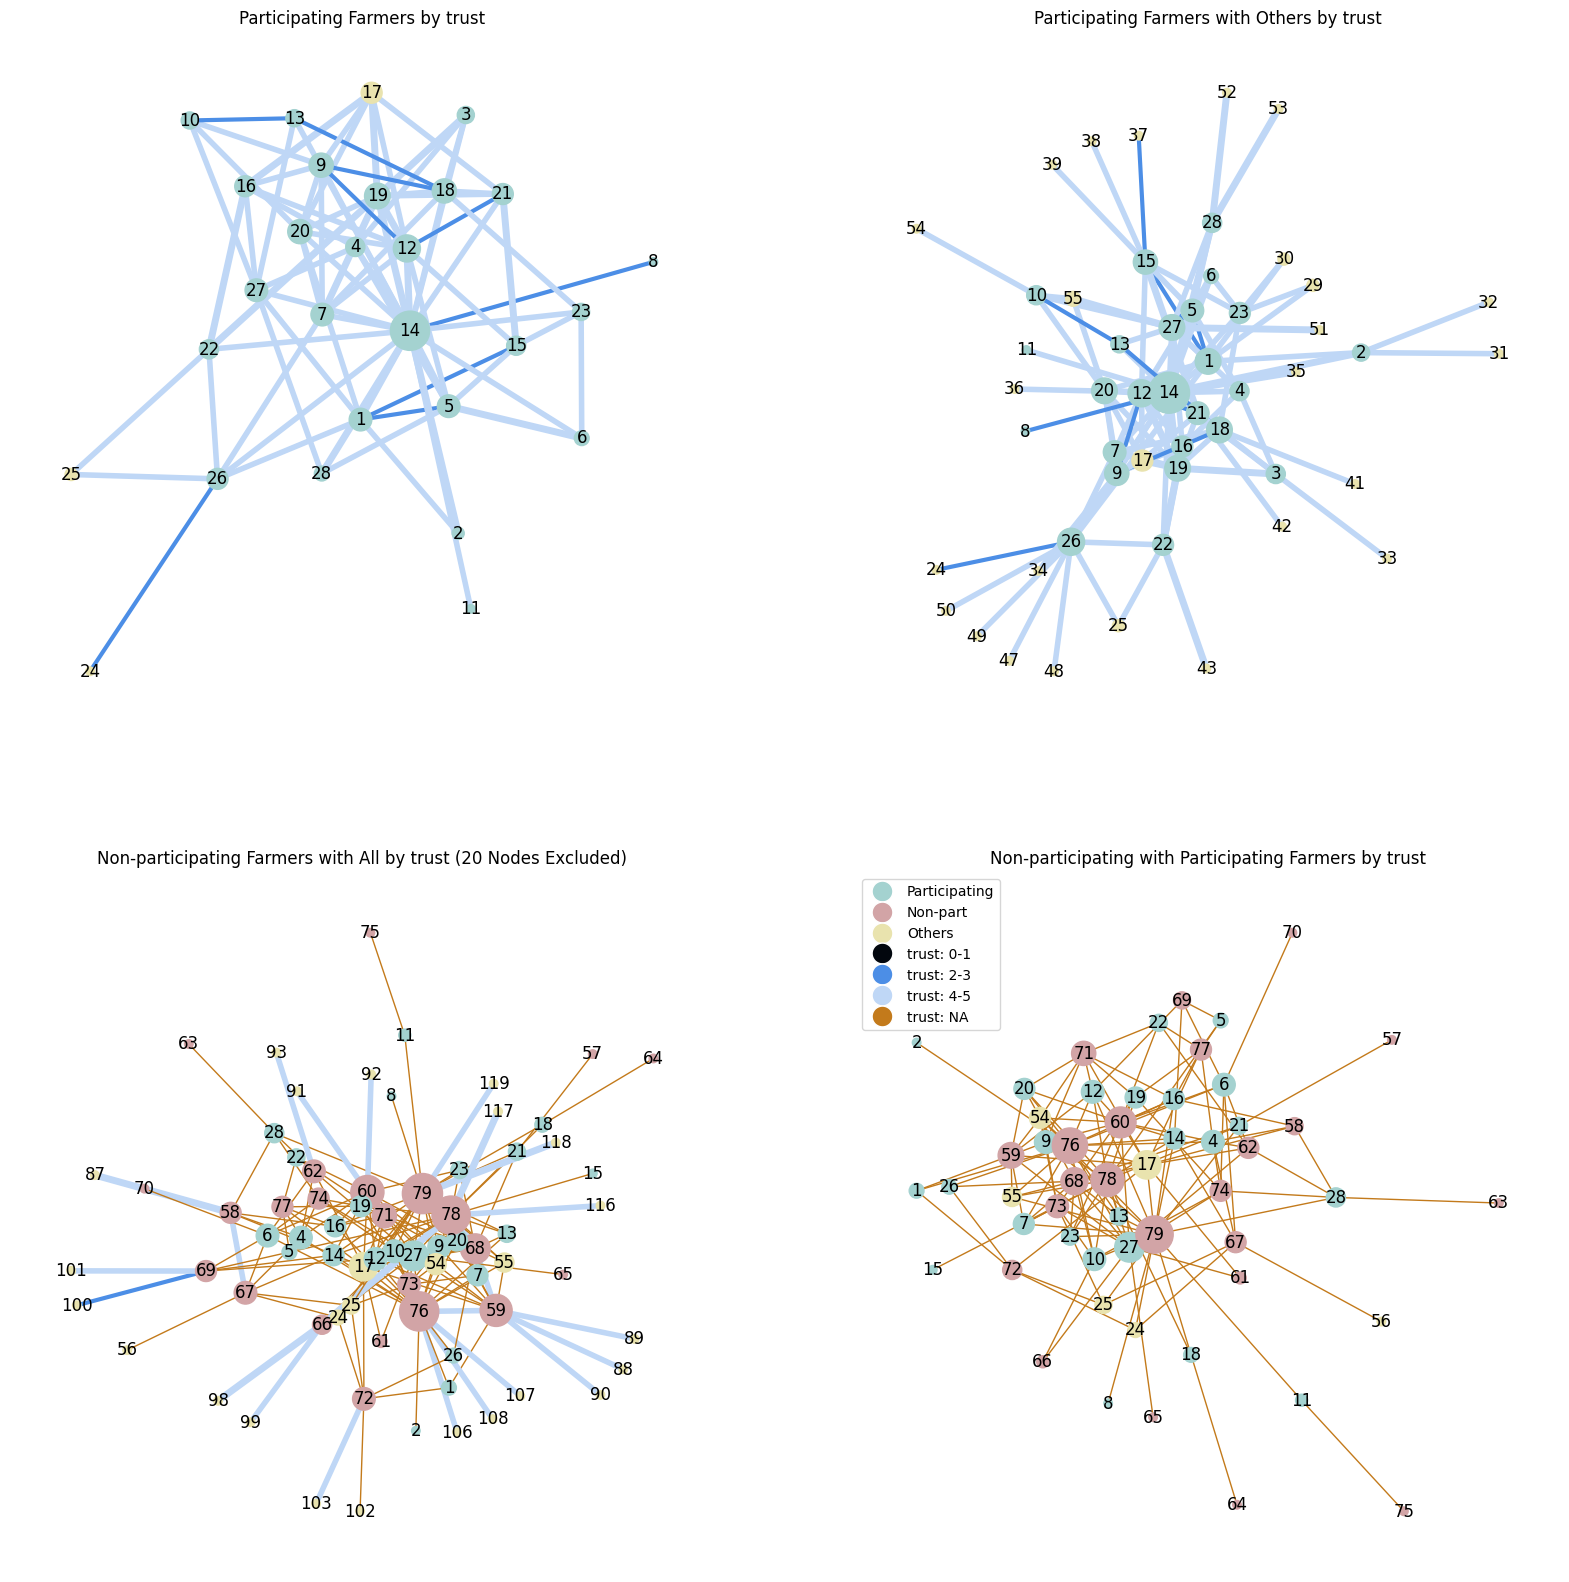

In [29]:
def graphing_by_attri(weight): 
    graphs = [part_part_G, part_others_G, non_all_G, non_part_G]
    titles = [f'Participating Farmers by {weight}', 
    f'Participating Farmers with Others by {weight}', 
    f'Non-participating Farmers with All by {weight} ({node_list_len} Nodes Excluded)', 
    f'Non-participating with Participating Farmers by {weight}']
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
    ax = axes.flatten()

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Participating',markerfacecolor='#a4d2d0', markersize=15),
        Line2D([0], [0], marker='o', color='w', label='Non-part',markerfacecolor='#d2a4a6', markersize=15),
        Line2D([0], [0], marker='o', color='w', label='Others',markerfacecolor='#e9e3ae', markersize=15),
        Line2D([0], [0], marker='o', color='w', label=f'{weight}: 0-1',markerfacecolor='#02070e', markersize=15),
        Line2D([0], [0], marker='o', color='w', label=f'{weight}: 2-3',markerfacecolor='#4c8ee6', markersize=15),
        Line2D([0], [0], marker='o', color='w', label=f'{weight}: 4-5',markerfacecolor='#bfd7f6', markersize=15),
        Line2D([0], [0], marker='o', color='w', label=f'{weight}: NA',markerfacecolor='#C37A1B', markersize=15),
        ]

    plt.legend(handles=legend_elements, loc='upper left')
   

    for i in range(4):
        widths = nx.get_edge_attributes(graphs[i], weight)
        nx.draw_networkx(graphs[i], pos=nx.spring_layout(graphs[i]),
        with_labels=True,
        node_color=colour_mapping(graphs[i]),
        node_size=list(dict([(node, degree*38) for node, degree in nx.degree(graphs[i])]).values()),
        font_size=12,
        edge_color=edge_color(graphs[i], weight),
        width=[float(i) if float(i) > 1 else 1.0 for i in list(widths.values())],
        ax=ax[i])
        ax[i].set_title(titles[i])
        ax[i].set_axis_off()

    plt.show()

graphing_by_attri('trust')

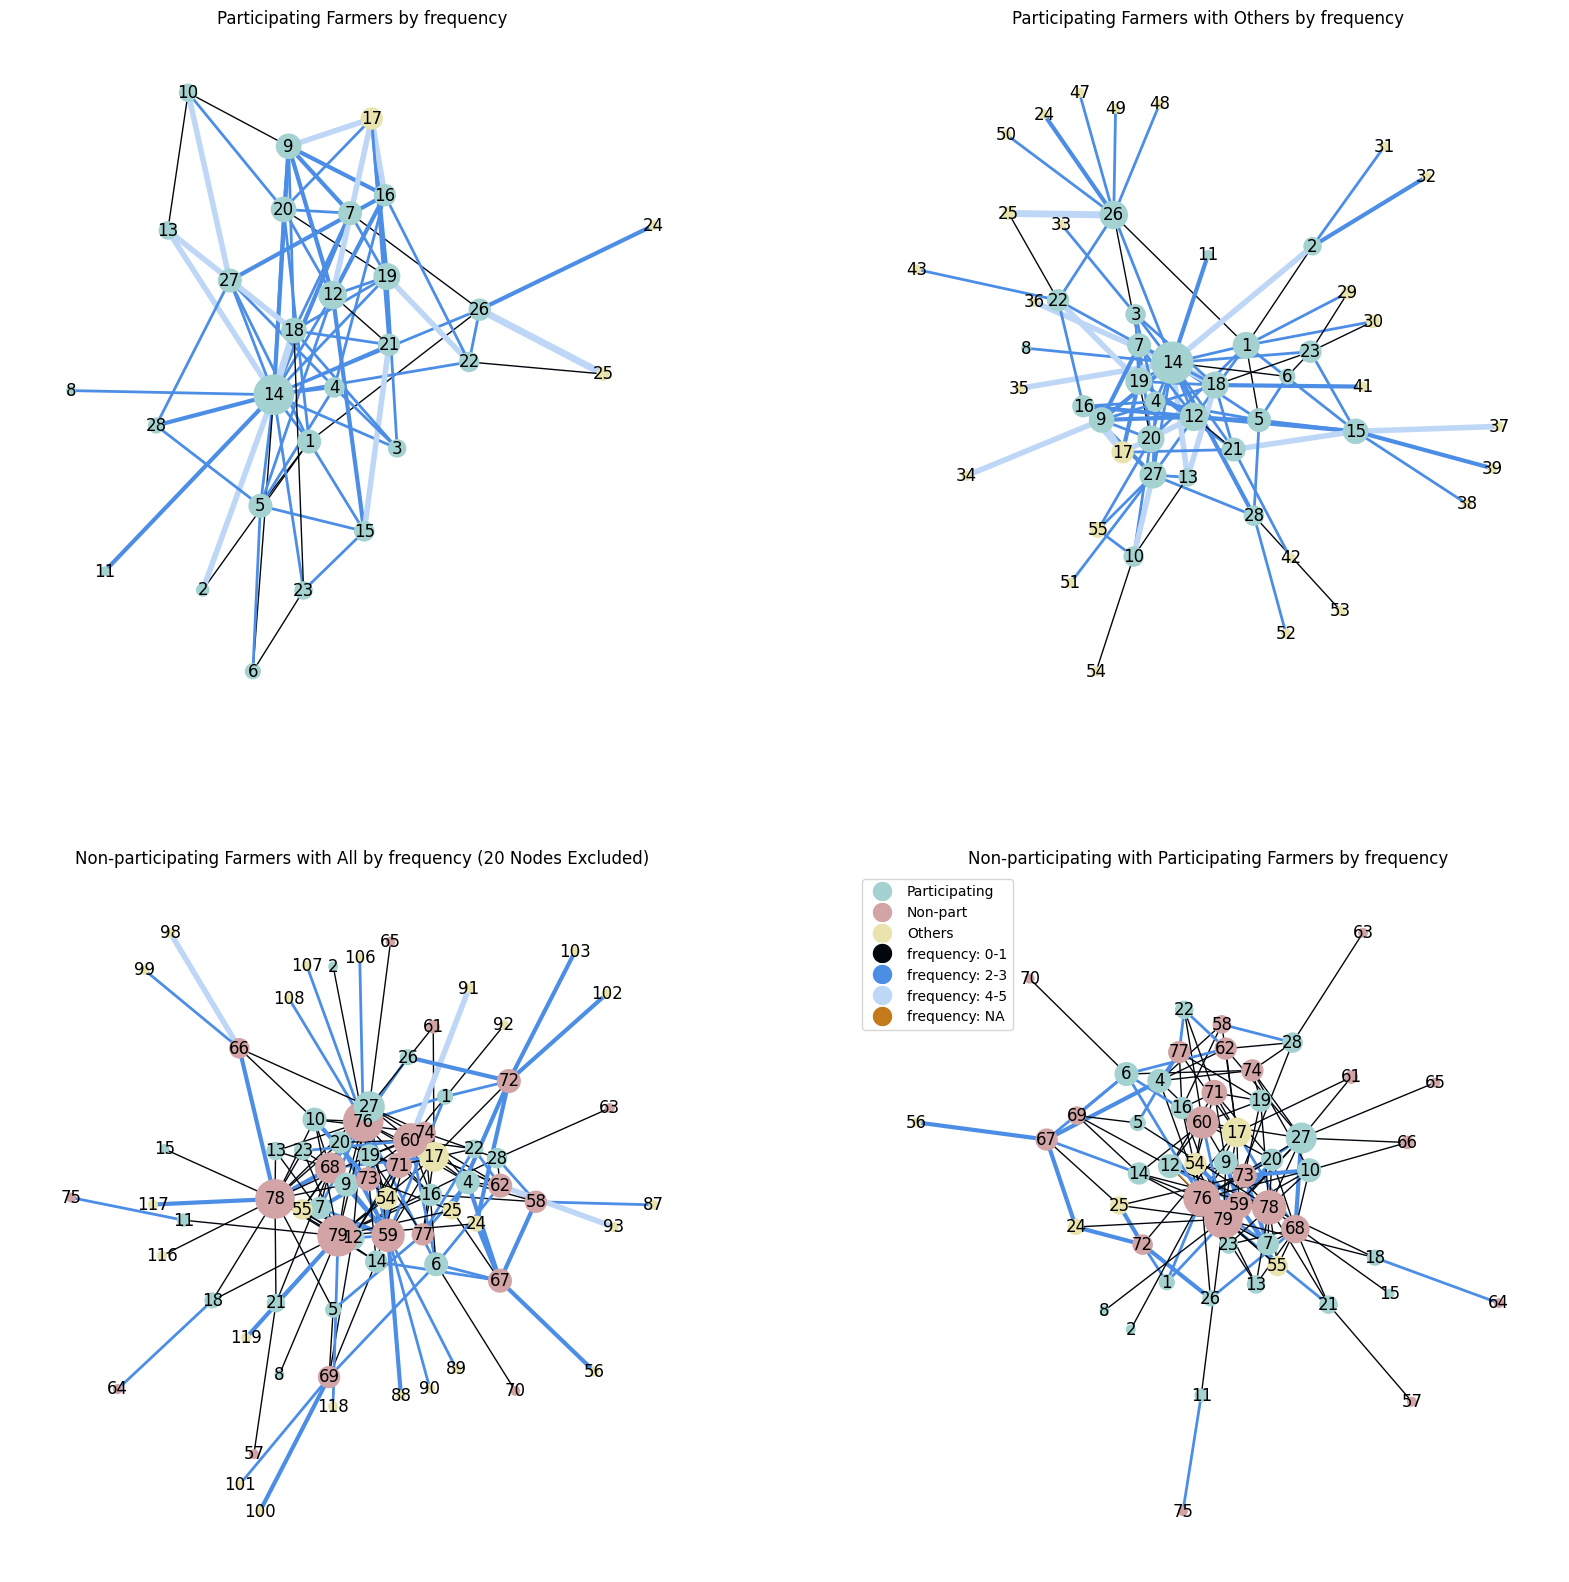

In [30]:
graphing_by_attri('frequency')

##### Influence Network

In [7]:
# Influence Dataset
inf_non_df = pd.read_csv('data/influence_nonagroconcept.csv',sep=";")
inf_non_df = inf_non_df.dropna()

inf_part_df = pd.read_csv('data/influence_agroconcept.csv',sep=";")
inf_part_df = inf_part_df.dropna()
inf_part_df.head()

# inf_non_G = nx.from_pandas_edgelist(inf_non_df, 'sender_id', 'receiver_id')
# [(inf_non_df.sender_id, inf_non_df.influence_x, inf_non_df.influence_x)]
# pos = {point: point for point in points}

,sender_id,receiver_id,influence_x,influence_y
1,2,28.0,0.721491,0.697368
2,2,9.0,0.749269,0.399671
3,2,54.0,0.591374,0.852522
4,2,14.0,0.426535,0.676535
5,2,19.0,0.615132,0.173794


#### Interactive Network Graph for All Farmers and Contacts

We have used the reference from https://melaniewalsh.github.io/Intro-Cultural-Analytics/06-Network-Analysis/02-Making-Network-Viz-with-Bokeh.html#network-with-responsive-highlighting for the following visualizations. 

In [16]:
G = nx.from_pandas_edgelist(all_farmers_df, 'sender_id', 'receiver_id', edge_attr=['frequency','trust'])

# Calculate degree for each node and add as node attribute
degrees = dict(nx.degree(G))
nx.set_node_attributes(G, name='degree', values=degrees)

# Slightly adjust degree so that the nodes with very small degrees are still visible
number_to_adjust_by = 5
adjusted_node_size = dict([(node, degree+number_to_adjust_by) for node, degree in nx.degree(G)])
nx.set_node_attributes(G, name='adjusted_node_size', values=adjusted_node_size)

# Calculate communities
communities = greedy_modularity_communities(G)
communities = communities[:-1]

# Create empty dictionaries
modularity_class = {}
# modularity_color = {}
#Loop through each community in the network
for community_number, community in enumerate(communities):
    #For each member of the community, add their community number and a distinct color
    for name in community: 
        modularity_class[name] = community_number
        # modularity_color[name] = Spectral8[community_number]

# Add modularity class and color as attributes from the network above
nx.set_node_attributes(G, modularity_class, 'modularity_class')
nx.set_node_attributes(G, part_colour, 'part_colour')

#Choose colors for node and edge highlighting
node_highlight_color = 'white'
edge_highlight_color = 'black'

#Choose attributes from G network to size and color by — setting manual size (e.g. 10) or color (e.g. 'skyblue') also allowed
size_by_this_attribute = 'adjusted_node_size'
color_by_this_attribute = 'part_colour'

#Pick a color palette — Blues8, Reds8, Purples8, Oranges8, Viridis8
color_palette = Blues8

#Choose a title!
title = 'Farmers Network'


#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [
       ("Farmer ID", "@index"),
        ("Degree", "@degree"),
        #  ("Modularity Class", "@modularity_class"),
        # ("Participating Color", "$color[swatch]:part_colour"),
        # ("Trust", "@trust"),
]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(G, nx.spring_layout, scale=10, center=(0, 0))

#Set node sizes and colors according to node degree (color as category from attribute)
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=color_by_this_attribute)
#Set node highlight colors
network_graph.node_renderer.hover_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)
network_graph.node_renderer.selection_glyph = Circle(size=size_by_this_attribute, fill_color=node_highlight_color, line_width=2)

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)
#Set edge highlight colors
network_graph.edge_renderer.selection_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)
network_graph.edge_renderer.hover_glyph = MultiLine(line_color=edge_highlight_color, line_width=2)

#Highlight nodes and edges
network_graph.selection_policy = NodesAndLinkedEdges()
network_graph.inspection_policy = NodesAndLinkedEdges()

plot.renderers.append(network_graph)

show(plot)
# save(plot, filename=f"{title}.html")
output_notebook()

Loading BokehJS ...